In [1]:
import netCDF4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import product
from glob import glob

In [2]:
# file name like sfc_grid_ta_202308292355.nc
def get_time_in_file_name(file_name):
    return file_name.split('_')[-1].split('.')[0]

In [3]:
# 2049 x 2049 x 168
tas = sorted(glob('SFC_GRID_29/*ta*.nc'))

ta_arr = np.empty((2049, 2049, len(tas)), dtype=np.int16)
data_scale = 10
for idx, file_name in enumerate(tas):
    ncfile = netCDF4.Dataset(file_name, "r", format="netcdf4")
    ta_arr[:,:,idx] = np.array(ncfile['data'])

ta_df = pd.DataFrame(ta_arr.reshape(-1, len(tas)).T,
                  columns=product(range(2049), range(2049)),
                  index=map(pd.Timestamp, map(get_time_in_file_name, tas))) / 10

In [4]:
# 2049 x 2049 x 168
tds = sorted(glob('SFC_GRID_29/*td*.nc'))

td_arr = np.empty((2049, 2049, len(tds)), dtype=np.int16)
data_scale = 10
for idx, file_name in enumerate(tds):
    ncfile = netCDF4.Dataset(file_name, "r", format="netcdf4")
    td_arr[:,:,idx] = np.array(ncfile['data'])

td_df = pd.DataFrame(td_arr.reshape(-1, len(tds)).T,
                  columns=product(range(2049), range(2049)),
                  index=map(pd.Timestamp, map(get_time_in_file_name, tds))) / 10

In [5]:
def show_graph(df, x, y, window_size, std, kind='temperature'):
    lines = df[(x, y)][window_size-1:]
    moving_avg = df[(x, y)].rolling(window=window_size).mean()[window_size-1:]
    moving_std = df[(x, y)].rolling(window=window_size).std()[window_size-1:]
    upper_bound = moving_avg + std * moving_std
    lower_bound = moving_avg - std * moving_std
    out_range_idx = (lines >= upper_bound) | (lines <= lower_bound)

    # plot a graph, moving_average and boundary
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(f'{kind} ({x}, {y}) with std={std} and window_size={window_size}({window_size*5}min)')
    ax.plot(lines, label=kind)
    ax.plot(moving_avg, color='gray', alpha=0.3, label='moving average')
    plt.fill_between(moving_avg.index,
                    moving_avg + std * moving_std,
                    moving_avg - std * moving_std,
                    color='gray', alpha=0.2)

    plt.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # get index outbound_max and inbound_min
    out_idx_max = (abs(lines[out_range_idx] - moving_avg[out_range_idx]) / moving_std).idxmax()
    out_val_max = (abs(lines[out_range_idx] - moving_avg[out_range_idx]) / moving_std).max()
    in_idx_min = (abs(lines[~out_range_idx] - moving_avg[~out_range_idx]) / moving_std).idxmin()
    in_val_min = (abs(lines[~out_range_idx] - moving_avg[~out_range_idx]) / moving_std).min()

    if not pd.isna(out_idx_max):
        ax.scatter(out_idx_max, lines[out_idx_max], color='r')
        ax.annotate(f'{out_val_max:.2f}', (out_idx_max, lines[out_idx_max]))
        # ax.set_xticks(np.append(ax.get_xticks(), [out_idx_max]))
        print(out_idx_max)
        ax.axvline(x=out_idx_max, ymax=(lines[out_idx_max] - ax.get_ylim()[0]) / (ax.get_ylim()[1] - ax.get_ylim()[0]), color='r', linestyle='--')
    if not pd.isna(in_idx_min):
        ax.scatter(in_idx_min, lines[in_idx_min], color='r')
        ax.annotate(f'{in_val_min:.2f}', (in_idx_min, lines[in_idx_min]))
        ax.axvline(x=in_idx_min, ymax=(lines[in_idx_min] - ax.get_ylim()[0]) / (ax.get_ylim()[1] - ax.get_ylim()[0]), color='r', linestyle='--')
        # ax.set_xticks([in_idx_min])
        print(in_idx_min)

    plt.show()

2023-08-29 14:40:00
2023-08-29 13:55:00


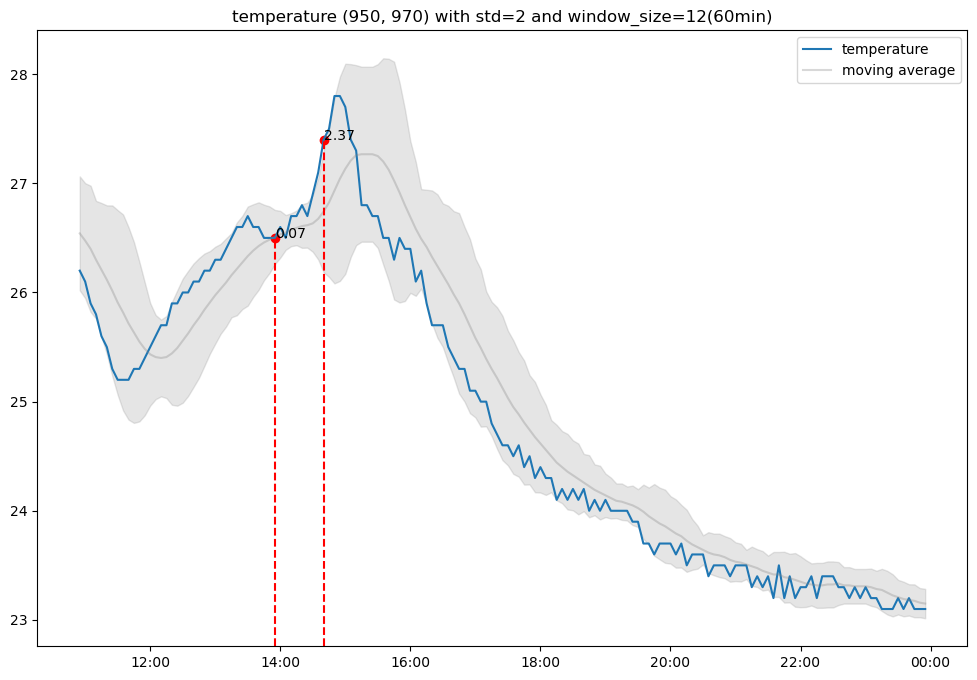

In [6]:
x=950
y=970
window_size=12
std=2
show_graph(df=ta_df, x=x, y=y, window_size=window_size, std=std, kind='temperature')